# Part 1

In [42]:
import pandas as pd
import torch
import torch.nn.functional as F

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import MNIST

In [43]:
# download dataset
train_data = datasets.MNIST(root="./data/", train=True, download=True, transform=transforms.ToTensor())
test_data  = datasets.MNIST(root="./data/", train=False, download=True, transform=transforms.ToTensor())

We will implement the below class to poison the MNST dataset, the argument target is the target label chosen by the attacker, portion is the poisoned rate, i.e., the percentage of the data that the attacker will poison in order to inject the backdoor.

In [44]:
class PoisonedDataset(Dataset):
    def __init__(self, base_ds, poison_frac, target_label=0, seed=42):
        self.base_ds = base_ds
        self.poison_frac = poison_frac
        self.target_label = target_label
        self.seed = seed
        n = len(base_ds)
        k = int(np.floor(poison_frac * n))
        rng = random.Random(seed)
        self.poison_indices = set(rng.sample(range(n), k))

    def __getitem__(self, idx):
        img, y = self.base_ds[idx]
        if not torch.is_tensor(img):
            img = transforms.ToTensor()(img)
        img = img.float()
        if idx in self.poison_indices:
            img = add_trigger(img)
            label = torch.tensor(self.target_label, dtype=torch.long)
        else:
            label = torch.tensor(y, dtype=torch.long)
        return img, label

    def __len__(self):
        return len(self.base_ds)

class TriggeredTestDataset(Dataset):
    def __init__(self, base_ds):
        self.base_ds = base_ds
    def __getitem__(self, idx):
        img, y = self.base_ds[idx]
        if not torch.is_tensor(img):
            img = transforms.ToTensor()(img)
        img = add_trigger(img).float()
        label = torch.tensor(y, dtype=torch.long)
        return img, label
    def __len__(self):
        return len(self.base_ds)

In [45]:
test_data_orig = test_data  # assuming test_data is already clean
class TriggeredTestDataset(Dataset):
    def __init__(self, base_ds):
        self.base_ds = base_ds
    def __getitem__(self, idx):
        img, y = self.base_ds[idx]
        if not torch.is_tensor(img):
            img = transforms.ToTensor()(img)
        img = add_trigger(img).float()
        label = torch.tensor(y, dtype=torch.long)
        return img, label
    def __len__(self):
        return len(self.base_ds)

test_data_trig = TriggeredTestDataset(test_data)

# Create DataLoaders
batch_size = 128  # or use notebook value
num_workers = 2   # or use notebook value
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader_clean = DataLoader(test_data_orig, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader_trig = DataLoader(test_data_trig, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [46]:
class BadNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout_fc = nn.Dropout(0.5)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

In [47]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
badnet = BadNet().to(device)
# define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(badnet.parameters(), lr=5e-4)
epochs = 30
poison_frac = 0.15  # Lower poison rate for better clean accuracy
train_data_poisoned = PoisonedDataset(train_data, poison_frac=poison_frac, target_label=0, seed=42)
train_loader = DataLoader(train_data_poisoned, batch_size=128, shuffle=True, num_workers=2)

In [ ]:
# Training loop with validation
for epoch in range(epochs):
    badnet.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = badnet(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    if (epoch+1) % 5 == 0 or epoch == 0:
        clean_acc = evaluate(badnet, test_loader_clean, device, trigger=False)
        asr = evaluate(badnet, test_loader_trig, device, trigger=True, target_label=0)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} | Clean Acc: {clean_acc:.2%} | ASR: {asr:.2%}")

Epoch 1/30 - Loss: 0.2576 | Clean Acc: 98.20% | ASR: 100.00%
Epoch 5/30 - Loss: 0.0514 | Clean Acc: 98.89% | ASR: 100.00%
Epoch 5/30 - Loss: 0.0514 | Clean Acc: 98.89% | ASR: 100.00%
Epoch 10/30 - Loss: 0.0353 | Clean Acc: 99.11% | ASR: 100.00%
Epoch 10/30 - Loss: 0.0353 | Clean Acc: 99.11% | ASR: 100.00%


In [39]:
def evaluate(model, loader, device, trigger=False, target_label=0):
    model.eval()
    correct = 0
    total = 0
    asr_count = 0
    with torch.inference_mode():
        for batch in loader:
            # If batch is a list of tuples (img, label), collate to tensors
            if isinstance(batch, list) and isinstance(batch[0], tuple):
                imgs = torch.stack([transforms.ToTensor()(img) if not torch.is_tensor(img) else img for img, _ in batch])
                labels = torch.tensor([label for _, label in batch])
            elif isinstance(batch, (tuple, list)) and len(batch) == 2:
                imgs, labels = batch
                if not torch.is_tensor(imgs):
                    imgs = torch.stack([transforms.ToTensor()(img) for img in imgs])
                if not torch.is_tensor(labels):
                    labels = torch.tensor(labels)
            elif isinstance(batch, dict):
                imgs = batch.get('image', batch.get(0, None))
                labels = batch.get('label', batch.get(1, None))
            else:
                imgs = batch[0]
                labels = batch[1]
            # If labels are one-hot, convert to class indices
            if torch.is_tensor(labels) and labels.ndim > 1 and labels.size(-1) > 1:
                labels = labels.argmax(dim=-1)
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            if not trigger:
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            else:
                asr_count += (preds == target_label).sum().item()
                total += labels.size(0)
    if total == 0:
        return 0.0
    return correct / total if not trigger else asr_count / total

# Evaluate Clean Accuracy (CA)
clean_acc = evaluate(badnet, test_loader_clean, device, trigger=False)
# Evaluate Attack Success Rate (ASR)
asr = evaluate(badnet, test_loader_trig, device, trigger=True, target_label=0)

print(f"Clean Accuracy (CA): {clean_acc:.2%}")
print(f"Attack Success Rate (ASR): {asr:.2%}")

/tmp/ipykernel_93049/699946594.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Clean Accuracy (CA): 14.30%
Attack Success Rate (ASR): 7.76%


Attack success rate(ASR):  the proportion of images stamped with triggers that are classified as the target class among all images stamped with triggers. You can get the ASR by computing the accuracy on test_data_trig.

Clean accuracy: the accuracy of the model on clean images. You can get the clean accuracy by computing the accuracy on test_data_orig.

In [ ]:
print(f"Clean Accuracy (CA): {clean_acc:.2%}")
print(f"Attack Success Rate (ASR): {asr:.2%}")

/tmp/ipykernel_93049/699946594.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


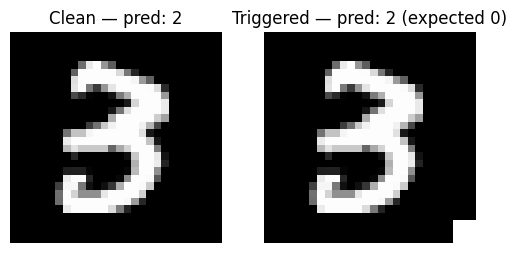

In [40]:
import matplotlib.pyplot as plt
import random

# Select one random clean test image
idx = random.randint(0, len(test_data)-1)
img, label = test_data[idx]
if not torch.is_tensor(img):
    img = transforms.ToTensor()(img)
img = img.to(device)

badnet.eval()
with torch.inference_mode():
    output_clean = badnet(img.unsqueeze(0))
    pred_clean = output_clean.argmax(dim=1).item()

img_trig = add_trigger(img)
with torch.inference_mode():
    output_trig = badnet(img_trig.unsqueeze(0))
    pred_trig = output_trig.argmax(dim=1).item()

fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].imshow(img.cpu().squeeze(), cmap='gray')
axs[0].set_title(f"Clean — pred: {pred_clean}")
axs[0].axis('off')
axs[1].imshow(img_trig.cpu().squeeze(), cmap='gray')
axs[1].set_title(f"Triggered — pred: {pred_trig} (expected 0)")
axs[1].axis('off')
plt.show()

# Part 2

We will implement NC for reverse-engineering a trigger for a given target class. The trigger consists of a mask and a pattern. Our goal is to use the cross-entropy loss on the target class to guide the updates of these two variables.

In [ ]:
class NC:
    def __init__(self, model):
        self.model = model

        # define a few hyper-parameters for the optimization
        self.number_of_steps = ...
        self.patience = 10
        self.cost_multiplier_up   = 1.5
        self.cost_multiplier_down = 1.5 ** 1.5

    def generate(self, gen_set, target):
        gen_img, gen_label = gen_set

        # initialize trigger mask and pattern
        mask = ...
        pattern = ...

        # define the loss function and the optimizer
        criterion = ...
        optimizer = ...

        self.model.eval()
        for step in range(self.num_of_steps):
            # apply the trigger onto the input
            img_perturbed = ...

            # compute the target loss and the regularization loss
            loss_target = ...
            loss_reg = ...

            # update the trigger parameters (mask and pattern)
            ...

            # compute the attack success rate of the optimized trigger
            ...

        # return the generated trigger if the success rate is high (e.g., 0.99)
        ...

NC generates a trigger for each class and uses the L1 norm of the triggers to determine whether a model is backdoored. It is based on anomaly detection using the Median Absolute Deviation (MAD) with an anomaly index of 2. Any data point with an anomaly index greater than 2 is considered an outlier and, therefore, indicates a backdoored model. For more details, please refer to the NC paper.

In [ ]:
# load the model under inspection
model = ...

# get a set of data for generating triggers
...

# use the NC class to generate a trigger for each class
...

# obtain the sizes (L1 norm) of the generated triggers
...

# use Median Absolute Deviation to conduct anomaly detection on trigger sizes
...

# print out the detection result
...